In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
import scipy.io as sio

In [2]:
project = 'kolmogorov'

In [3]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = True
latent_dim = 20

In [5]:
L1, L2 = 2*np.pi, 2*np.pi
n1, n2 = 64, 64

grid_x = np.linspace(0,L1-L1/n1,n1)
grid_y = np.linspace(0,L2-L2/n2,n2)

grid_x, grid_y = np.meshgrid(grid_x, grid_y)

Kx = np.concatenate([np.arange(0, n1//2), np.arange(-n1//2, 0)]) * (2 * np.pi / L1)
Ky = np.concatenate([np.arange(0, n2//2), np.arange(-n2//2, 0)]) * (2 * np.pi / L2)

kx, ky = np.meshgrid(Kx,Ky)

dt_sim = 0.5
T_sim = 10000
nt = int(T_sim/dt_sim)

In [6]:
u1 = np.load(f'{project_root}/data/{project}/u1.npy') 
u2 = np.load(f'{project_root}/data/{project}/u2.npy')
w = np.load(f'{project_root}/data/{project}/vorticity.npy')
nt, n1, n2 = u1.shape

X, scaler = transform_data_for_AE(u1,u2)
X_flat = X.reshape(X.shape[0], -1)

data = transform_data_for_AE_inverse(X, scaler)

print(f"Data shape: {X.shape}, Flat shape: {X_flat.shape}")

Data shape: (20000, 2, 64, 64), Flat shape: (20000, 8192)


In [7]:
# === Consistent train/val/test split ===
train_idx, val_idx, test_idx = split_indices(nt, split=(0.3, 0.2, 0.5))

X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (6000, 2, 64, 64), Val shape: (4000, 2, 64, 64), Test shape: (10000, 2, 64, 64)


In [8]:
mlp_input_dim = X.reshape(X.shape[0], -1).shape[1]

In [9]:
pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')
mlp = MLP_AE(input_dim=mlp_input_dim, latent_dim=latent_dim)
mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'))
mlp.to(device)
cnn = CNN_AE(latent_dim=latent_dim)
cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
cnn.to(device);

In [10]:
# Compute test error for each model

# 1. PCA only (reconstruction from PCA)
X_pca_recon, Z_pca = pca.forward(X)
X_pca_recon = X_pca_recon.reshape(X.shape)
X_pca_recon = transform_data_for_AE_inverse(X_pca_recon, scaler)
pca_test_mse = np.mean((data[test_idx] - X_pca_recon[test_idx]) ** 2)
print(f"PCA test RMSE: {np.sqrt(pca_test_mse):.6f}")

# 2. PCA + MLP Autoencoder
mlp.eval()
with torch.no_grad():
    X_mlp_recon, Z_mlp = mlp(torch.tensor(X, dtype=torch.float32, device=device))
    X_mlp_recon = X_mlp_recon.cpu().numpy()
    X_mlp_recon = X_mlp_recon.reshape(X.shape)
    X_mlp_recon = transform_data_for_AE_inverse(X_mlp_recon, scaler)

    mlp_test_mse = np.mean((data[test_idx] - X_mlp_recon[test_idx]) ** 2)
print(f"MLP AE test RMSE: {np.sqrt(mlp_test_mse):.6f}")

# 3. CNN Autoencoder (batched to avoid CUDA OOM)
cnn.eval()
batch_size = 16  
n_samples = X.shape[0]
X_cnn_recon = []
with torch.no_grad():
    for i in range(0, n_samples, batch_size):
        batch = X[i:i+batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32, device=device)
        recon_batch, _ = cnn(batch_tensor)
        X_cnn_recon.append(recon_batch.cpu().numpy())
X_cnn_recon = np.concatenate(X_cnn_recon, axis=0)
X_cnn_recon = transform_data_for_AE_inverse(X_cnn_recon, scaler)
cnn_test_mse = np.mean((data[test_idx] - X_cnn_recon[test_idx]) ** 2)
print(f"CNN AE test RMSE: {np.sqrt(cnn_test_mse):.6f}")


PCA test RMSE: 0.227951
MLP AE test RMSE: 0.177517
CNN AE test RMSE: 0.118724


In [11]:
# Calculate vorticity from predictions of each model

# 1. PCA
u1_pca = X_pca_recon[:, 0].reshape(-1, n1, n2)
u2_pca = X_pca_recon[:, 1].reshape(-1, n1, n2)
w_pca = vort(u1_pca, u2_pca, kx, ky)

# 2. MLP AE
u1_mlp = X_mlp_recon[:, 0].reshape(-1, n1, n2)
u2_mlp = X_mlp_recon[:, 1].reshape(-1, n1, n2)
w_mlp = vort(u1_mlp, u2_mlp, kx, ky)

# 3. CNN AE
u1_cnn = X_cnn_recon[:, 0].reshape(-1, n1, n2)
u2_cnn = X_cnn_recon[:, 1].reshape(-1, n1, n2)
w_cnn = vort(u1_cnn, u2_cnn, kx, ky)

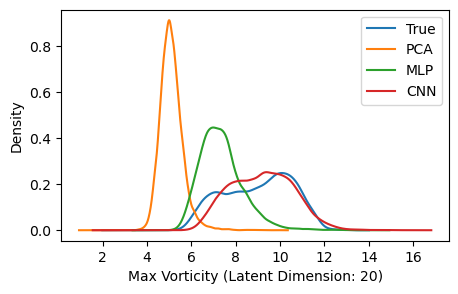

In [12]:
# Compute maximum vorticity for each model and the true data
max_w_true = np.max(np.abs(w), axis=(1,2))
max_w_pca = np.max(np.abs(w_pca), axis=(1,2))
max_w_mlp = np.max(np.abs(w_mlp), axis=(1,2))
max_w_cnn = np.max(np.abs(w_cnn), axis=(1,2))

plt.figure(figsize=(5, 3))
for max_w, label in [
    (max_w_true, 'True'),
    (max_w_pca, 'PCA'),
    (max_w_mlp, 'MLP'),
    (max_w_cnn, 'CNN')
]:
    kde_x, kde_y = custom_KDE(max_w).evaluate()
    plt.plot(kde_x, kde_y, label=label)
plt.xlabel('Max Vorticity (Latent Dimension: {})'.format(latent_dim))
plt.ylabel('Density')
plt.legend()
# plt.title('KDE of Maximum Vorticity')
plt.savefig(f'{project_root}/figures/{project}/rom/kde_max_vorticity_latent_dim_{latent_dim}.png', bbox_inches='tight', dpi=300)
plt.show()


In [19]:
# Helper function to compute RMSE for a given set of indices
def compute_rmse(true, pred, idx):
    return np.sqrt(np.mean((true[idx] - pred[idx]) ** 2))

sets = {
    'Train': train_idx,
    'Val': val_idx,
    'Test': test_idx
}

# Max vorticity RMSE
for set_name, idx in sets.items():
    rmse_pca = compute_rmse(max_w_true, max_w_pca, idx)
    rmse_mlp = compute_rmse(max_w_true, max_w_mlp, idx)
    rmse_cnn = compute_rmse(max_w_true, max_w_cnn, idx)
    print(f"{set_name} max vorticity RMSE: PCA={rmse_pca:.6f}, MLP={rmse_mlp:.6f}, CNN={rmse_cnn:.6f}")

# u1, u2, omega RMSE
for set_name, idx in sets.items():
    u1_true_set = data[idx, 0]
    u2_true_set = data[idx, 1]
    w_true_set = w[idx]

    u1_pca_set = u1_pca[idx]
    u2_pca_set = u2_pca[idx]
    w_pca_set = w_pca[idx]

    u1_mlp_set = u1_mlp[idx]
    u2_mlp_set = u2_mlp[idx]
    w_mlp_set = w_mlp[idx]

    u1_cnn_set = u1_cnn[idx]
    u2_cnn_set = u2_cnn[idx]
    w_cnn_set = w_cnn[idx]

    rmse_u1_pca = compute_rmse(u1_true_set, u1_pca_set, np.arange(len(idx)))
    rmse_u2_pca = compute_rmse(u2_true_set, u2_pca_set, np.arange(len(idx)))
    rmse_w_pca = compute_rmse(w_true_set, w_pca_set, np.arange(len(idx)))

    rmse_u1_mlp = compute_rmse(u1_true_set, u1_mlp_set, np.arange(len(idx)))
    rmse_u2_mlp = compute_rmse(u2_true_set, u2_mlp_set, np.arange(len(idx)))
    rmse_w_mlp = compute_rmse(w_true_set, w_mlp_set, np.arange(len(idx)))

    rmse_u1_cnn = compute_rmse(u1_true_set, u1_cnn_set, np.arange(len(idx)))
    rmse_u2_cnn = compute_rmse(u2_true_set, u2_cnn_set, np.arange(len(idx)))
    rmse_w_cnn = compute_rmse(w_true_set, w_cnn_set, np.arange(len(idx)))

    print(f"{set_name} RMSE:")
    print(f"  PCA: u1={rmse_u1_pca:.6f}, u2={rmse_u2_pca:.6f}, omega={rmse_w_pca:.6f}")
    print(f"  MLP: u1={rmse_u1_mlp:.6f}, u2={rmse_u2_mlp:.6f}, omega={rmse_w_mlp:.6f}")
    print(f"  CNN: u1={rmse_u1_cnn:.6f}, u2={rmse_u2_cnn:.6f}, omega={rmse_w_cnn:.6f}")


Train max vorticity RMSE: PCA=4.123163, MLP=2.053798, CNN=0.787035
Val max vorticity RMSE: PCA=4.116898, MLP=2.082452, CNN=0.890792
Test max vorticity RMSE: PCA=4.123722, MLP=2.094890, CNN=0.887992
Train RMSE:
  PCA: u1=0.201541, u2=0.241505, omega=1.274006
  MLP: u1=0.144667, u2=0.167998, omega=0.990107
  CNN: u1=0.078214, u2=0.082744, omega=0.564554
Val RMSE:
  PCA: u1=0.203038, u2=0.243128, omega=1.279204
  MLP: u1=0.162471, u2=0.184166, omega=1.065034
  CNN: u1=0.112831, u2=0.116334, omega=0.694490
Test RMSE:
  PCA: u1=0.206741, u2=0.247349, omega=1.293613
  MLP: u1=0.166533, u2=0.187860, omega=1.086791
  CNN: u1=0.117518, u2=0.119917, omega=0.713970


Closest test indices: [13639 16350  1462 10698 18174  8190  2418 11112 16044  6229 13327 15246
  4961  5114  6731  6658  3346 12352 11447 17918]
Corresponding RMSEs: [0.62915997 0.62915611 0.62925322 0.62913137 0.62907416 0.62906132
 0.62903373 0.62901909 0.62937194 0.62938789 0.62941307 0.6294211
 0.6294838  0.62952007 0.62885891 0.62953652 0.62959624 0.62874451
 0.62872478 0.62863893]


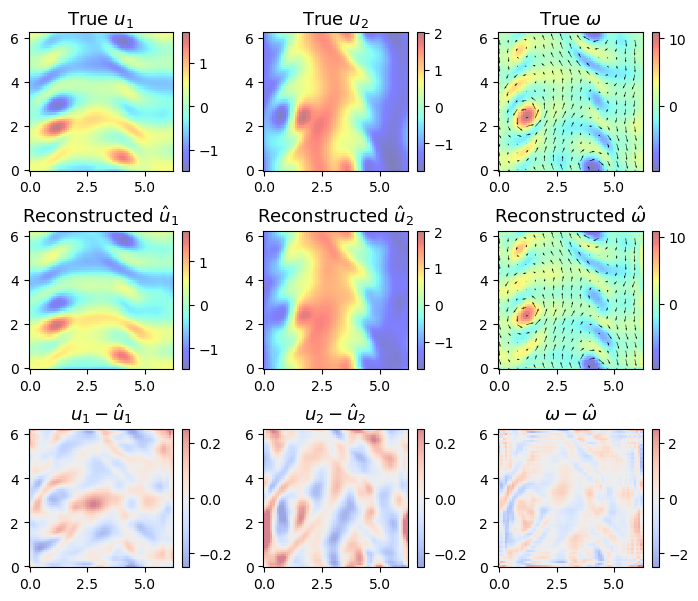

In [24]:
# Compute per-sample RMSE for CNN vorticity on test set
rmse_per_sample = np.sqrt(np.mean((w[test_idx] - w_cnn[test_idx])**2, axis=(1,2)))
avg_rmse = np.mean(rmse_per_sample)

# Find the 20 test indices closest to the average RMSE, pick the 15th for visualization
closest_indices = np.argsort(np.abs(rmse_per_sample - avg_rmse))[:20]
idx = test_idx[closest_indices[14]]

print("Closest test indices:", test_idx[closest_indices])
print("Corresponding RMSEs:", rmse_per_sample[closest_indices])

fs = 13
fig, axes = plt.subplots(3, 3, figsize=(7, 6))

# Helper for plotting fields
def plot_data(ax, field, title, cmap, vmin=None, vmax=None, alpha=0.5, colorbar=True, quiver=None):
    mesh = ax.pcolormesh(grid_x, grid_y, field, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    ax.set_title(title, fontsize=fs)
    if colorbar:
        fig.colorbar(mesh, ax=ax)
    if quiver is not None:
        ax.quiver(grid_x[::4, ::4], grid_y[::4, ::4], quiver[0][::4, ::4], quiver[1][::4, ::4], color='black')

# True fields
plot_data(axes[0, 0], u1[idx], 'True $u_1$', 'jet', vmin=np.min(u1[idx]), vmax=np.max(u1[idx]))
plot_data(axes[0, 1], u2[idx], 'True $u_2$', 'jet', vmin=np.min(u2[idx]), vmax=np.max(u2[idx]))
plot_data(axes[0, 2], w[idx], 'True $\omega$', 'jet', vmin=np.min(w[idx]), vmax=np.max(w[idx]), quiver=(u1[idx], u2[idx]))

# CNN reconstructed fields
plot_data(axes[1, 0], u1_cnn[idx], 'Reconstructed $\hat{u}_1$', 'jet', vmin=np.min(u1[idx]), vmax=np.max(u1[idx]))
plot_data(axes[1, 1], u2_cnn[idx], 'Reconstructed $\hat{u}_2$', 'jet', vmin=np.min(u2[idx]), vmax=np.max(u2[idx]))
plot_data(axes[1, 2], w_cnn[idx], 'Reconstructed $\hat{\omega}$', 'jet', vmin=np.min(w[idx]), vmax=np.max(w[idx]), quiver=(u1_cnn[idx], u2_cnn[idx]))

# Differences
diff_u1 = u1[idx] - u1_cnn[idx]
diff_u2 = u2[idx] - u2_cnn[idx]
diff_w = w[idx] - w_cnn[idx]
vmin_u = np.min([diff_u1, diff_u2])
vmax_u = np.max([diff_u1, diff_u2])

vmin_u, vmax_u = -0.25, 0.25

plot_data(axes[2, 0], diff_u1, '$u_1 - \hat{u}_1$', 'coolwarm', vmin=vmin_u, vmax=vmax_u)
plot_data(axes[2, 1], diff_u2, '$u_2 - \hat{u}_2$', 'coolwarm', vmin=vmin_u, vmax=vmax_u)
plot_data(axes[2, 2], diff_w, '$\omega - \hat{\omega}$', 'coolwarm', vmin=-2.5, vmax=2.5)

plt.tight_layout(pad=0.65)
plt.savefig(f'{project_root}/figures/{project}/rom/CNN_autoencoder_error_latent_dim_{latent_dim}_idx_{idx}.png', dpi=300, bbox_inches='tight')
plt.show()
